In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


import warnings
warnings.filterwarnings(action='ignore') 

# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 회귀
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
pd.set_option('display.max_row', 5000)
pd.set_option('display.max_columns', 100)

from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
sang_data = pd.read_excel('C:\\농업기술원\\1차\\2018\\2018-2019 토마토_생육(원본)/오마이토마토_오길택_생육.xlsx')
env_data = pd.read_excel('C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)/오마이토마토_오길택_환경.xlsx')

In [4]:
env_data=env_data[['date', '내부온도', '내부습도','CO2','누적일사량']]

In [5]:
env_data.columns

Index(['date', '내부온도', '내부습도', 'CO2', '누적일사량'], dtype='object')

# 생육에 주차 추가

In [6]:
# 주차 추가
def add_weeknum(sang_df):
    sang_df['diff']=sang_df['WeekNum'].shift(1)
    sang_df['diff2']=sang_df['WeekNum']-sang_df['diff']
    
    num=-1
    test_week=[]
    for i in range(len(sang_df)):
        if sang_df['diff2'].loc[i]!=0:
            num+=1
            test_week.append(num)
        else:
            test_week.append(num)
    del sang_df['diff']
    del sang_df['diff2']
    return test_week

In [7]:
sang_data['주차']=add_weeknum(sang_data)

In [8]:
sang_data=sang_data[['Date','Sample','주차','생장길이']]

# 생육 이상치 제거 (선택에 따라 이 과정 안하고 넘어가도 됨) 

In [9]:
q1 = sang_data['생장길이'].quantile(0.25)
q3 = sang_data['생장길이'].quantile(0.75)

iqt = 1.5 * (q3 - q1)

# 이상치 제거

sang_data_delout=sang_data[(sang_data['생장길이'] < (q3 + iqt)) & (sang_data['생장길이'] > (q1 - iqt))]




# 환경 12시간 단위로 끊기

In [10]:
# 12시간 짤라서 Date 추가
def env_add_Date(env_df,생육조사기간):
    df=pd.DataFrame()
    for i in range(len(생육조사기간)-1):
        start_i = 생육조사기간[i]+timedelta(hours=12)
        end_i = 생육조사기간[i+1]+timedelta(hours=12)

        df2 = env_df[(env_df['date']>=start_i) & (env_df['date']<end_i)]
        df2['Date']=생육조사기간[i+1]


        df=pd.concat([df,df2])
    return df

In [11]:
생육조사기간=sorted(list(set(list(sang_data['Date']))))
env_data=env_add_Date(env_data,생육조사기간)

# 환경날짜와 측정 날짜의 차이를 구함

In [12]:
env_data['n_date']=env_data['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [13]:
def n_date(d):
    myDatetimeStr = d
    myDatetime = datetime.strptime(myDatetimeStr, '%Y-%m-%d')
    return myDatetime

In [14]:
env_data['n_date']=env_data['n_date'].apply(n_date)

In [15]:
env_data['diff']=env_data['Date']-env_data['n_date']

In [16]:
env_data.head(10)

,date,내부온도,내부습도,CO2,누적일사량,Date,n_date,diff
126,2018-08-12 12:00:00,34.5,76.2,305,1481.41,2018-08-19,2018-08-12,7 days
127,2018-08-12 13:00:00,33.0,72.4,313,1482.18,2018-08-19,2018-08-12,7 days
128,2018-08-12 14:00:00,32.0,75.0,312,1482.96,2018-08-19,2018-08-12,7 days
129,2018-08-12 15:00:00,32.5,76.3,309,1483.75,2018-08-19,2018-08-12,7 days
130,2018-08-12 16:00:00,33.7,74.1,301,1484.68,2018-08-19,2018-08-12,7 days
131,2018-08-12 17:00:00,34.2,66.1,301,1486.27,2018-08-19,2018-08-12,7 days
132,2018-08-12 18:00:00,33.9,64.5,305,1487.39,2018-08-19,2018-08-12,7 days
133,2018-08-12 19:00:00,31.3,71.4,326,1487.56,2018-08-19,2018-08-12,7 days
134,2018-08-12 20:00:00,28.3,82.2,354,1487.56,2018-08-19,2018-08-12,7 days
135,2018-08-12 21:00:00,27.3,85.7,366,1487.56,2018-08-19,2018-08-12,7 days


# 일사량 해결

In [17]:
def cumsum_to_value(df):
    #누적일사량 해결
    df['lag_누적일사량']=df['누적일사량'].shift(1)
    df['일사량2']=df['누적일사량']-df['lag_누적일사량']

    #음수를 0으로 치환 NA를 0으로 치환
    df['일사량2_치환']=df['일사량2'].apply(lambda x : 0 if x<0 else x)
    df['일사량']=df['일사량2_치환'].fillna(0)

    del df['lag_누적일사량']
    del df['일사량2']
    del df['일사량2_치환']
    return df

In [18]:
base_col=['date','Date']
cumsum_list=['누적일사량']
cumsum_col=base_col+cumsum_list

cumsum_df=cumsum_to_value(env_data[cumsum_col])
env_data['일사량']=cumsum_df['일사량']
del env_data['누적일사량']

# 환경 주차 생성

In [19]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=env_data.replace({"Date":dic})["Date"]
    return result

In [20]:
env_data['주차']=match_test_weeknum(sang_data,env_data)

# 환경 pivot

In [21]:
def remove_outlier_pivot(df,col,aggfunc):
    cut_df=pd.DataFrame()
    for i in range(len(df['주차'].unique())):
        k=df[df['주차']==i+1]
        
        
        q1 = k[col].quantile(0.25)
        q3 = k[col].quantile(0.75)

        iqt = 1.5 * (q3 - q1)

        # 이상치 제거

        k=k[(k[col] < (q3 + iqt)) & (k[col] > (q1 - iqt))]
        
        cut_df=pd.concat([cut_df,k])

    result = cut_df.pivot_table(index=['n_date'],
                               values=col,
                               aggfunc=aggfunc).reset_index(drop=False)

    return result

In [22]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['date','Date','주차','diff']
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']
cols=avg_list+sum_list
aggfunc=['mean']*len(avg_list)+['sum']*len(sum_list)

In [23]:

i=0
for col,agg in zip(cols,aggfunc):
    df=env_data[[col,'n_date','주차']]

    # 이상치 제거, 피봇
    my_pivot = remove_outlier_pivot(df,col,agg)
    
    if i==0:
        result = my_pivot
        i+=1
        continue

    result = pd.merge(result,my_pivot,how='inner',on='n_date')



In [24]:
result.head(5)

,n_date,내부온도,내부습도,CO2,일사량
0,2018-08-12,31.075000,76.766667,334.416667,6.15
1,2018-08-13,30.439130,79.465217,371.260870,26.05
2,2018-08-14,29.982609,80.652174,375.913043,24.70
3,2018-08-15,30.117391,78.473913,360.391304,16.27
4,2018-08-16,29.400000,80.021739,347.695652,21.14


# 지연변수 생성(하루)

In [25]:
p=result
lag_result=result
for i in range(20):
    raw_col=p.columns[1:]
    later_df=p.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'일전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    lag_result=pd.concat([lag_result,later_df],axis=1)


In [26]:
lag_result.head(5)

,n_date,내부온도,내부습도,CO2,일사량,_1일전_내부온도,_1일전_내부습도,_1일전_CO2,_1일전_일사량,_2일전_내부온도,_2일전_내부습도,_2일전_CO2,_2일전_일사량,_3일전_내부온도,_3일전_내부습도,_3일전_CO2,_3일전_일사량,_4일전_내부온도,_4일전_내부습도,_4일전_CO2,_4일전_일사량,_5일전_내부온도,_5일전_내부습도,_5일전_CO2,_5일전_일사량,_6일전_내부온도,_6일전_내부습도,_6일전_CO2,_6일전_일사량,_7일전_내부온도,_7일전_내부습도,_7일전_CO2,_7일전_일사량,_8일전_내부온도,_8일전_내부습도,_8일전_CO2,_8일전_일사량,_9일전_내부온도,_9일전_내부습도,_9일전_CO2,_9일전_일사량,_10일전_내부온도,_10일전_내부습도,_10일전_CO2,_10일전_일사량,_11일전_내부온도,_11일전_내부습도,_11일전_CO2,_11일전_일사량,_12일전_내부온도,_12일전_내부습도,_12일전_CO2,_12일전_일사량,_13일전_내부온도,_13일전_내부습도,_13일전_CO2,_13일전_일사량,_14일전_내부온도,_14일전_내부습도,_14일전_CO2,_14일전_일사량,_15일전_내부온도,_15일전_내부습도,_15일전_CO2,_15일전_일사량,_16일전_내부온도,_16일전_내부습도,_16일전_CO2,_16일전_일사량,_17일전_내부온도,_17일전_내부습도,_17일전_CO2,_17일전_일사량,_18일전_내부온도,_18일전_내부습도,_18일전_CO2,_18일전_일사량,_19일전_내부온도,_19일전_내부습도,_19일전_CO2,_19일전_일사량,_20일전_내부온도,_20일전_내부습도,_20일전_CO2,_20일전_일사량
0,2018-08-12,31.075000,76.766667,334.416667,6.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-08-13,30.439130,79.465217,371.260870,26.05,31.075000,76.766667,334.416667,6.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-08-14,29.982609,80.652174,375.913043,24.70,30.439130,79.465217,371.260870,26.05,31.075000,76.766667,334.416667,6.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-08-15,30.117391,78.473913,360.391304,16.27,29.982609,80.652174,375.913043,24.70,30.439130,79.465217,371.260870,26.05,31.07500,76.766667,334.416667,6.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-08-16,29.400000,80.021739,347.695652,21.14,30.117391,78.473913,360.391304,16.27,29.982609,80.652174,375.913043,24.70,30.43913,79.465217,371.260870,26.05,31.075,76.766667,334.416667,6.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 주차 추가

In [27]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=env_data.replace({"n_date":dic})["n_date"]
    return result

In [28]:
lag_result['주차']=match_test_weeknum(sang_data,lag_result)

In [29]:
for i in range(len(lag_result)):
    if type(lag_result['주차'].iloc[i])==int:
        k=lag_result['주차'].iloc[i]
    else:
        lag_result['주차'].iloc[i]=k

In [30]:
lag_result=lag_result.iloc[:,1:]

# 병합

In [31]:
merge_dataset = pd.merge(sang_data,lag_result,how='inner',on='주차')
merge_dataset_delout = pd.merge(sang_data_delout,lag_result,how='inner',on='주차')

In [32]:
dataset=merge_dataset.dropna()
dataset_delout=merge_dataset_delout.dropna()

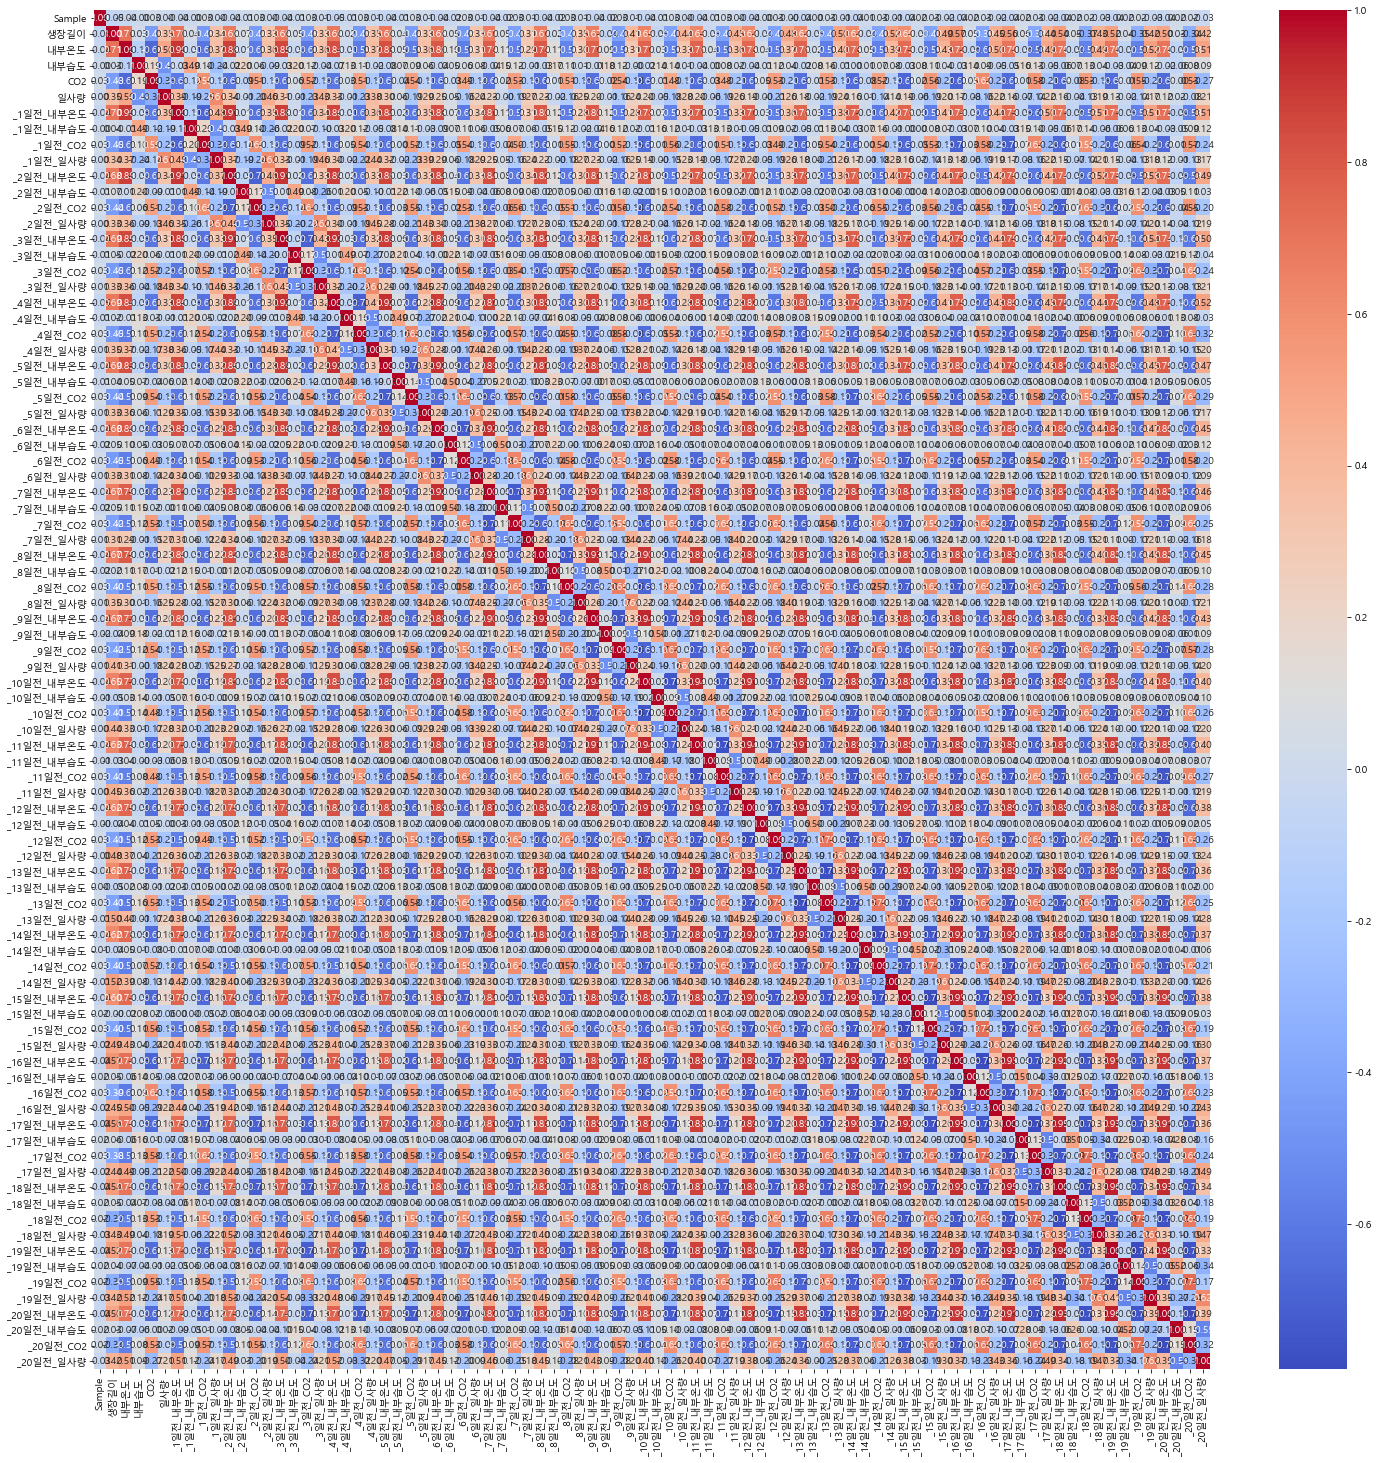

In [33]:
plt.figure(figsize=(25,25))
g = sns.heatmap(dataset.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# XGBOOST

In [34]:
from sklearn.datasets import load_boston
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold

In [44]:
def xgb(df,Y,type=None):
    if type=='all':
        test_size=0.3
    else:
        test_size=0.25
    xgb_model = xgboost.XGBRegressor(n_estimators=100, gamma=0,
                               colsample_bytree=1, max_depth=7)

    parameters = {'eta':[0.064,0.0645,0.065,0.0655,0.066],
                 'learning_rate':[0.19,0.2,0.21],
                 'subsample':[0.695,0.7,0.705]}
    xgb_regressor = GridSearchCV(xgb_model,parameters,scoring='neg_mean_squared_error',cv=10)

    x_train=df.iloc[:,[2]+list(range(4,len(df.columns)))]
    y_train=df[Y]
    xgb_regressor.fit(x_train,y_train)
    print(xgb_regressor.best_params_)
    
    eta=xgb_regressor.best_params_['eta']
    learning_rate=xgb_regressor.best_params_['learning_rate']
    subsample = xgb_regressor.best_params_['subsample']
    
    # Kfold
    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size)
    xgb_model = xgboost.XGBRegressor(n_estimators=100,  gamma=0,colsample_bytree=1, max_depth=7,
                                     learning_rate=learning_rate,
                                     subsample=subsample,
                                     eta=eta
                           )

    print(len(X_train), len(X_test))
    
    xgb_model.fit(X_train,y_train)
    predictions = xgb_model.predict(X_test)
    RMSE = mean_squared_error(y_test, predictions)**0.5
    print(RMSE)
    
    
    xgboost.plot_importance(xgb_model)
    
    if type!='all':
        plt.figure(figsize=[15,7])
  #  f, ax = plt.subplots(1, 1)
    else: 
        plt.figure(figsize=[24,12])
    sns.lineplot(x=range(len(predictions)),y=predictions,label="pred")
    sns.lineplot(x=range(len(y_test)),y=y_test,label="Test")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    return RMSE

In [36]:
y='생장길이'
dataset['주차']=pd.to_numeric(dataset['주차'])

{'eta': 0.07, 'learning_rate': 0.2, 'subsample': 0.7}
898 300
1.5983683062598828


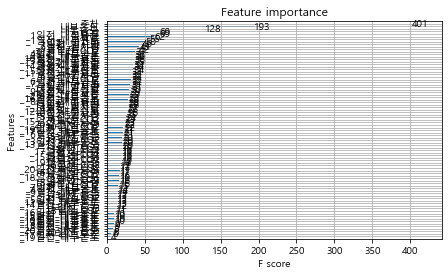

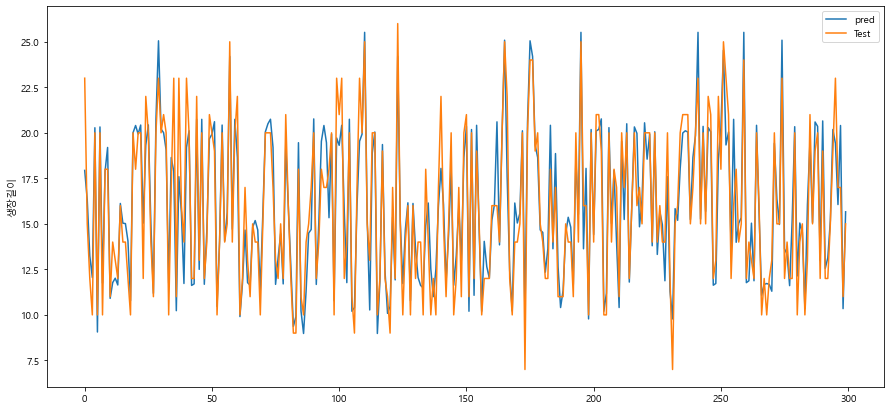

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


1.5983683062598828

In [37]:
xgb(dataset,y)

In [45]:
y='생장길이'
dataset_delout['주차']=pd.to_numeric(dataset_delout['주차'])

{'eta': 0.064, 'learning_rate': 0.19, 'subsample': 0.705}
898 300
1.4291459830284277


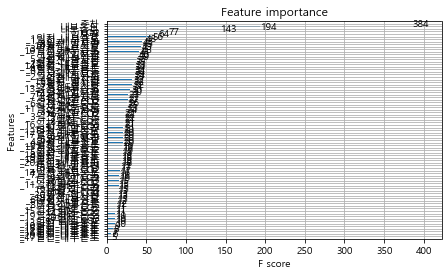

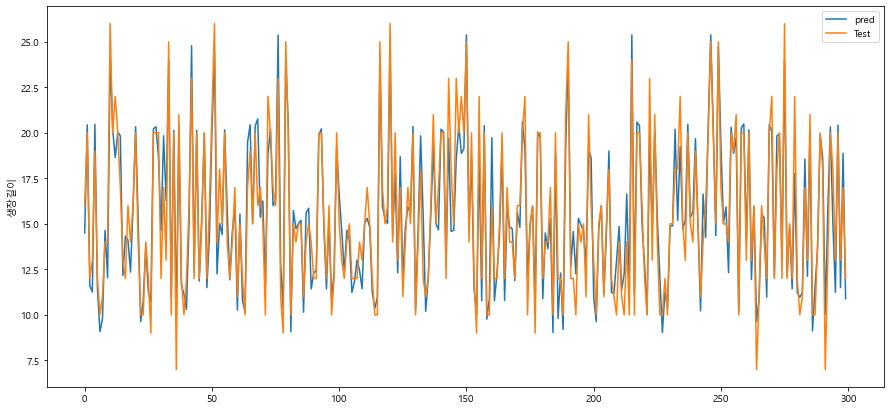

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


1.4291459830284277

In [46]:
xgb(dataset_delout,y)

In [ ]:
{'eta': 0.065, 'learning_rate': 0.2, 'subsample': 0.7}

# 양액 적용